# Group Knockoffs

This tutorial generates group (model-X) knockoffs, which is useful when predictors are highly correlated. The methodology is described in the following paper

> Dai R, Barber R. The knockoff filter for FDR control in group-sparse and multitask regression. InInternational conference on machine learning 2016 Jun 11 (pp. 1851-1859). PMLR.


!!! note

    In the original paper, Dai and Barber only describes how to construct a suboptimal equi-correlated group knockoffs. Here we implement fully generalized alternatives.
    
Currently available options for group knockoffs:
+ `:mvr`: Fully general minimum variance-based reconstructability (MVR) group knockoff, based on coordinate descent.
+ `:maxent`: Fully general maximum entropy (maxent) group knockoff, based on coordinate descent.
+ `:equi`: This implements the equi-correlated idea proposed in [Barber and Dai](https://proceedings.mlr.press/v48/daia16.html), which lets $S_j = \gamma \Sigma_{(G_j, G_j)}$ where $\Sigma_{(G_j, G_j)}$ is the block of $\Sigma$ containing variables in the $j$th group. Thus, instead of optimizing over all variables in $S$, we optimize a scalar $\gamma$. Conveniently, there a simple closed form solution for $\gamma$. For `mvr` and `maxent` group knockoffs, we initialize $S$ using this construction. 
+ `:SDP`: This generalizes the equi-correlated group knockoff idea by having $S_j = \gamma_j \Sigma_{(G_j, G_j)}$. Instead of optimizing over all variables in $S$, we optimize over a vector $\gamma_1,...,\gamma_G$. 


In [1]:
# load packages for this tutorial
using Revise
using Knockoffs
using LinearAlgebra
using Random
using StatsBase
using Statistics
using ToeplitzMatrices
using Distributions
using Clustering
using ProgressMeter
using Plots
gr(fmt=:png);

# some helper functions to compute power and empirical FDR
function TP(correct_groups, signif_groups)
    return length(signif_groups ∩ correct_groups) / length(correct_groups)
end
function TP(correct_groups, β̂, groups)
    signif_groups = get_signif_groups(β̂, groups)
    return TP(correct_groups, signif_groups)
end
function FDR(correct_groups, signif_groups)
    FP = length(signif_groups) - length(signif_groups ∩ correct_groups) # number of false positives
    FDR = FP / max(1, length(signif_groups))
    return FDR
end
function FDR(correct_groups, β̂, groups)
    signif_groups = get_signif_groups(β̂, groups)
    return FDR(correct_groups, signif_groups)
end
function get_signif_groups(β, groups)
    correct_groups = Int[]
    for i in findall(!iszero, β)
        g = groups[i]
        g ∈ correct_groups || push!(correct_groups, g)
    end
    return correct_groups
end

┌ Info: Precompiling Knockoffs [878bf26d-0c49-448a-9df5-b057c815d613]
└ @ Base loading.jl:1423
┌ Warning: Package Knockoffs does not have Clustering in its dependencies:
│ - If you have Knockoffs checked out for development and have
│   added Clustering as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Knockoffs
└ Loading Clustering into Knockoffs from project dependency, future warnings for Knockoffs are suppressed.


get_signif_groups (generic function with 1 method)

# Constructing group knockoffs

First, let's simulate data and generate equi-correlated knockoffs. Our true covariance matrix looks like

```math
\begin{aligned}
\Sigma = 
\begin{pmatrix}
    1 & \rho & \rho^2 & ... & \rho^p\\
    \rho & 1 & & ... & \rho^{p-1}\\
    \vdots & & & 1 & \vdots \\
    \rho^p & \cdots & & & 1
\end{pmatrix}, \quad \rho = 0.9
\end{aligned}
```

Because variables are highly correlated with its neighbors ($\rho = 0.9$), it becomes difficult to distinguish which variables among a group are truly causal. Thus, group knockoffs which test whether a *group* of variables have any signal should have better power than standard (single-variable) knockoffs. 

First, lets simulate some data

In [2]:
# simulate data
Random.seed!(2022)
n = 1000 # sample size
p = 200  # number of covariates
k = 10   # number of true predictors
Σ = simulate_AR1(p, a=3, b=1) # true covariance matrix
# Σ = Matrix(SymmetricToeplitz(0.9.^(0:(p-1)))) # true covariance matrix
groupsizes = [5 for i in 1:div(p, 5)] # each group has 5 variables
groups = vcat([i*ones(g) for (i, g) in enumerate(groupsizes)]...) |> Vector{Int}
# groups = partition_groups(X, cutoff=0.7)
true_mu = zeros(p)
L = cholesky(Σ).L
X = randn(n, p) * L
zscore!(X, mean(X, dims=1), std(X, dims=1)); # standardize columns of X

Generate group knockoffs with the exported function `modelX_gaussian_group_knockoffs`. Similar to non-group knockoffs, group knockoff accepts keyword arguments `m`, `tol`, `niter`, and `verbose` which controls the algorithm's behavior. 

In [3]:
Gmvr = modelX_gaussian_group_knockoffs(
    X, :mvr, groups, true_mu, Σ, 
    m = 1,          # number of knockoffs per variable to generate
    tol = 0.01,   # convergence tolerance
    niter = 10,    # max number of coordinate descent iterations
    backtrack=true,
    verbose=true);  # whether to print informative intermediate results

initial obj = 1.286139833061612e6
Iter 1: obj = 10455.388907171458, δ = 0.777303421481526, t1 = 10.17, t2 = 0.09, t3 = 0.0
Iter 2: obj = 9488.484514499563, δ = 0.46183579880045256, t1 = 19.78, t2 = 0.14, t3 = 0.0
Iter 3: obj = 9433.980123381662, δ = 0.032048413590059235, t1 = 25.79, t2 = 0.19, t3 = 0.0
Iter 4: obj = 9416.05981683253, δ = 0.012482119845367083, t1 = 28.66, t2 = 0.23, t3 = 0.0
Iter 5: obj = 9409.476940392207, δ = 0.005804972315675189, t1 = 32.54, t2 = 0.27, t3 = 0.01


In [4]:
Gme = modelX_gaussian_group_knockoffs(
    X, :maxent, groups, true_mu, Σ, 
    m = 1,          # number of knockoffs per variable to generate
    tol = 0.01,   # convergence tolerance
    niter = 10,    # max number of coordinate descent iterations
    backtrack=true,
    robust=false,
    verbose=true);  # whether to print informative intermediate results

initial obj = -1252.8379618375245
Iter 1: obj = -694.2747111515464, δ = 0.8213605782741042, t1 = 0.08, t2 = 0.01, t3 = 0.0
Iter 2: obj = -676.5261554211446, δ = 0.1530404317893599, t1 = 0.09, t2 = 0.02, t3 = 0.0
Iter 3: obj = -673.3809993438289, δ = 0.023163901000981202, t1 = 0.1, t2 = 0.04, t3 = 0.0
Iter 4: obj = -672.2392946965166, δ = 0.01101839441020275, t1 = 0.11, t2 = 0.05, t3 = 0.0
Iter 5: obj = -671.7984208711497, δ = 0.005918051997198304, t1 = 0.12, t2 = 0.06, t3 = 0.0


In [12]:
Gsdp = modelX_gaussian_group_knockoffs(
    X, :sdp, groups, true_mu, Σ, 
    m = 1,          # number of knockoffs per variable to generate
    tol = 0.01,   # convergence tolerance
    niter = 5,    # max number of block descent iterations
    verbose=true);  # whether to print informative intermediate results

Init obj = 661.4164410843318


┌ Warning: cannot step in centering direction
└ @ Hypatia.Solvers /Users/biona001/.julia/packages/Hypatia/gNjn6/src/Solvers/steppers/combined.jl:106


Iter 1 δ = 0.9887315781661968, obj = 391.1311493800152


┌ Warning: cannot step in centering direction
└ @ Hypatia.Solvers /Users/biona001/.julia/packages/Hypatia/gNjn6/src/Solvers/steppers/combined.jl:106
┌ Warning: cannot step in centering direction
└ @ Hypatia.Solvers /Users/biona001/.julia/packages/Hypatia/gNjn6/src/Solvers/steppers/combined.jl:106


Iter 2 δ = 0.07175690719997307, obj = 391.1256012471294


┌ Warning: cannot step in centering direction
└ @ Hypatia.Solvers /Users/biona001/.julia/packages/Hypatia/gNjn6/src/Solvers/steppers/combined.jl:106
┌ Warning: cannot step in centering direction
└ @ Hypatia.Solvers /Users/biona001/.julia/packages/Hypatia/gNjn6/src/Solvers/steppers/combined.jl:106


Iter 3 δ = 0.39664668824327987, obj = 390.0257475432737


┌ Warning: cannot step in centering direction
└ @ Hypatia.Solvers /Users/biona001/.julia/packages/Hypatia/gNjn6/src/Solvers/steppers/combined.jl:106


Iter 4 δ = 0.010841705181814487, obj = 390.0257470814529


┌ Warning: cannot step in centering direction
└ @ Hypatia.Solvers /Users/biona001/.julia/packages/Hypatia/gNjn6/src/Solvers/steppers/combined.jl:106
┌ Warning: cannot step in centering direction
└ @ Hypatia.Solvers /Users/biona001/.julia/packages/Hypatia/gNjn6/src/Solvers/steppers/combined.jl:106


Iter 5 δ = 0.0, obj = 390.0257470814529


In [16]:
@time Gsdp_subopt = modelX_gaussian_group_knockoffs(
    X, :sdp_subopt, groups, true_mu, Σ, 
    m = 1,          # number of knockoffs per variable to generate
    tol = 0.0001,   # convergence tolerance
    niter = 100,    # max number of coordinate descent iterations
    backtrack=false,
    verbose=true);  # whether to print informative intermediate results

  2.026790 seconds (1.23 M allocations: 121.773 MiB, 1.48% gc time, 30.77% compilation time)


In [17]:
sum(Gmvr.S), sum(Gme.S), sum(Gsdp.S), sum(Gsdp_subopt.S)

(43.38600994009782, 58.62658724437401, 268.53187701117815, 161.80686081124745)

Note $t_1, t_2, t_3$ are timers which corresponds to (1) updating cholesky factors, (2) solving forward-backward equations, and (3) solving off-diagonal 1D optimization problems using Brent's method. As we can see, the computational bottleneck in (2), which we dispatch to efficient LAPACK libraries. 

The output is a struct with the following fields
```julia
struct GaussianGroupKnockoff{T<:AbstractFloat, BD<:AbstractMatrix, S<:Symmetric} <: Knockoff
    X::Matrix{T} # n × p design matrix
    X̃::Matrix{T} # n × p knockoff of X
    groups::Vector{Int} # p × 1 vector of group membership
    S::BD # p × p block-diagonal matrix of the same size as Σ. S and 2Σ - S are both psd
    γs::Vector{T} # scalars chosen so that 2Σ - S is positive definite where S_i = γ_i * Σ_i
    Σ::S # p × p symmetric covariance matrix. 
    method::Symbol # method for solving s
end
```
Given this result, lets do a sanity check: is $2\Sigma - S$ positive semi-definite?

In [4]:
# compute minimum eigenvalues of 2Σ - S
eigmin(2Gme.Σ - Gme.S)

0.417481414774321

## Second order group knockoffs

In practice, we often do not have the true covariance matrix $\Sigma$ and the true means $\mu$. In that case, we can generate second order group knockoffs via the 3 argument function

In [5]:
Gme_second_order = modelX_gaussian_group_knockoffs(X, :maxent, groups);

This will estimate the covariance matrix via a shrinkage estimator, see documentation API for more details. 

## Lasso Example

Lets repeat the simulation in Fig 9 of [Spector and Janson](https://projecteuclid.org/journals/annals-of-statistics/volume-50/issue-1/Powerful-knockoffs-via-minimizing-reconstructability/10.1214/21-AOS2104.short).  

### AR(1)

Here causal variables are scatter uniformly

In [58]:
target_fdr = 0.1
m = 1
p = 500
k = 50
n = 250 # sample size
nsims = 10
c_corrs = 0.7:0.1:1 # between 1 (ungrouped) and 0.7 (~3 variable per group)

sdp_power, sdp_fdr = zeros(length(c_corrs)), zeros(length(c_corrs))
mvr_power, mvr_fdr = zeros(length(c_corrs)), zeros(length(c_corrs))
me_power, me_fdr = zeros(length(c_corrs)), zeros(length(c_corrs))

pmeter = Progress(nsims*length(c_corrs))
for sim in 1:nsims, (idx, c_corr) in enumerate(c_corrs)
    # simulate AR1 Σ
    Σ = simulate_AR1(p, a=3, b=1)

    # simulate X
    Random.seed!(sim)
    L = cholesky(Σ).L
    X = randn(n, p) * L
    zscore!(X, mean(X, dims=1), std(X, dims=1))

    # single-linkage heirarchical clustering to define groups
    groups = partition_groups(X, cutoff=c_corr)

    # simulate y
    δ = 2
    βtrue = zeros(p)
    βtrue[1:k] .= rand(-1:2:1, k) .* rand(Uniform(δ/2, δ), k)
    shuffle!(βtrue)
    ϵ = randn(n)
    y = X * βtrue + ϵ;

    # find truly causal groups
    correct_groups = get_signif_groups(βtrue, groups)

    # sdp
    t = @elapsed ko_filter = fit_lasso(y, X, method=:sdp, groups=groups, m=m)
    fdr_idx = findfirst(x -> x == target_fdr, ko_filter.fdr_target)
    power = round(TP(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    fdr = round(FDR(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    sdp_power[idx] += power
    sdp_fdr[idx] += fdr
    
    # suboptimal me
    t = @elapsed ko_filter = fit_lasso(y, X, method=:maxent_subopt, groups=groups, m=m)
    power = round(TP(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    fdr = round(FDR(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    mvr_power[idx] += power
    mvr_fdr[idx] += fdr
    
    # fully general me
    t = @elapsed ko_filter = fit_lasso(y, X, method=:maxent, groups=groups, m=m)
    power = round(TP(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    fdr = round(FDR(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    me_power[idx] += power
    me_fdr[idx] += fdr
    
    next!(pmeter)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:44:38


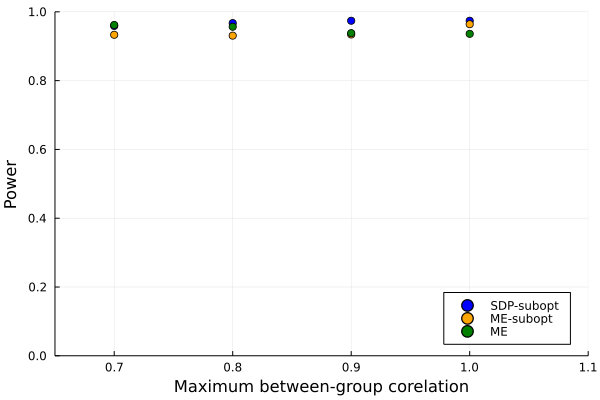

In [61]:
power_plt = plot(; xlim=(0.65, 1.1), xlabel="Maximum between-group corelation", ylim=(0, 1), 
    ylabel="Power", legend=:bottomright)
scatter!(power_plt, c_corrs, sdp_power ./ nsims, label="SDP-subopt", color="blue")
scatter!(power_plt, c_corrs, mvr_power ./ nsims, label="ME-subopt", color="orange")
scatter!(power_plt, c_corrs, me_power ./ nsims, label="ME", color="green")

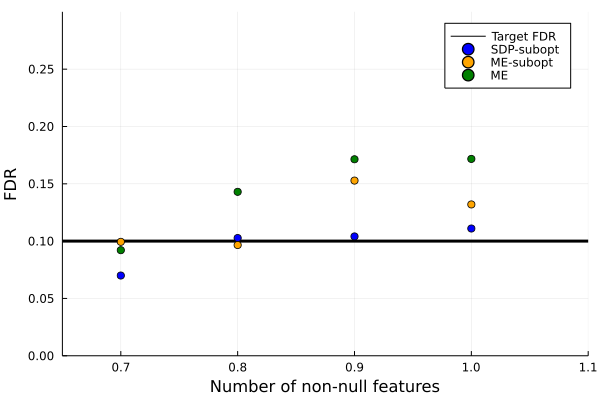

In [62]:
fdr_plt = plot(; xlim=(0.65, 1.1), xlabel="Number of non-null features", ylim=(0, 0.3), ylabel="FDR")
hline!(fdr_plt, [target_fdr], label="Target FDR", w=3, color="black")
scatter!(fdr_plt, c_corrs, sdp_fdr ./ nsims, label="SDP-subopt", color="blue")
scatter!(fdr_plt, c_corrs, mvr_fdr ./ nsims, label="ME-subopt", color="orange")
scatter!(fdr_plt, c_corrs, me_fdr ./ nsims, label="ME", color="green")

### AR(1)(corr)

Here causal variables are all contiguous

In [63]:
target_fdr = 0.1
m = 1
p = 500
k = 50
n = 250 # sample size
nsims = 10
c_corrs = 0.7:0.1:1 # between 1 (ungrouped) and 0.7 (~3 variable per group)

sdp_power, sdp_fdr = zeros(length(c_corrs)), zeros(length(c_corrs))
mvr_power, mvr_fdr = zeros(length(c_corrs)), zeros(length(c_corrs))
me_power, me_fdr = zeros(length(c_corrs)), zeros(length(c_corrs))

pmeter = Progress(nsims*length(c_corrs))
for sim in 1:nsims, (idx, c_corr) in enumerate(c_corrs)
    # simulate AR1 Σ
    Σ = simulate_AR1(p, a=3, b=1)

    # simulate X
    Random.seed!(sim)
    L = cholesky(Σ).L
    X = randn(n, p) * L
    zscore!(X, mean(X, dims=1), std(X, dims=1))

    # single-linkage heirarchical clustering to define groups
    distmat = 1 .- cor(X)
    cluster_result = hclust(distmat; linkage=:single)
    groups = cutree(cluster_result, h=1-c_corr)

    # simulate y
    δ = 2
    βtrue = zeros(p)
    start_idx = rand(1:p-k)
    causal_idx = start_idx:start_idx+k-1
    βtrue[causal_idx] .= rand(-1:2:1, k) .* rand(Uniform(δ/2, δ), k)
    ϵ = randn(n)
    y = X * βtrue + ϵ;

    # find truly causal groups
    correct_groups = get_signif_groups(βtrue, groups)

    # suboptimal sdp
    t = @elapsed ko_filter = fit_lasso(y, X, method=:sdp, groups=groups, m=m)
    fdr_idx = findfirst(x -> x == target_fdr, ko_filter.fdr_target)
    power = round(TP(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    fdr = round(FDR(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    sdp_power[idx] += power
    sdp_fdr[idx] += fdr
    
    # suboptimal me
    t = @elapsed ko_filter = fit_lasso(y, X, method=:maxent_subopt, groups=groups, m=m)
    power = round(TP(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    fdr = round(FDR(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    mvr_power[idx] += power
    mvr_fdr[idx] += fdr
    
    # fully general me
    t = @elapsed ko_filter = fit_lasso(y, X, method=:maxent, groups=groups, m=m)
    power = round(TP(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    fdr = round(FDR(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    me_power[idx] += power
    me_fdr[idx] += fdr
    
    next!(pmeter)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:43:55


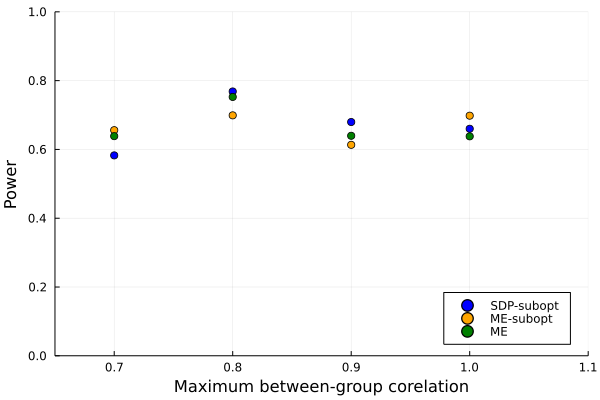

In [64]:
power_plt = plot(; xlim=(0.65, 1.1), xlabel="Maximum between-group corelation", ylim=(0, 1), 
    ylabel="Power", legend=:bottomright)
scatter!(power_plt, c_corrs, sdp_power ./ nsims, label="SDP-subopt", color="blue")
scatter!(power_plt, c_corrs, mvr_power ./ nsims, label="ME-subopt", color="orange")
scatter!(power_plt, c_corrs, me_power ./ nsims, label="ME", color="green")

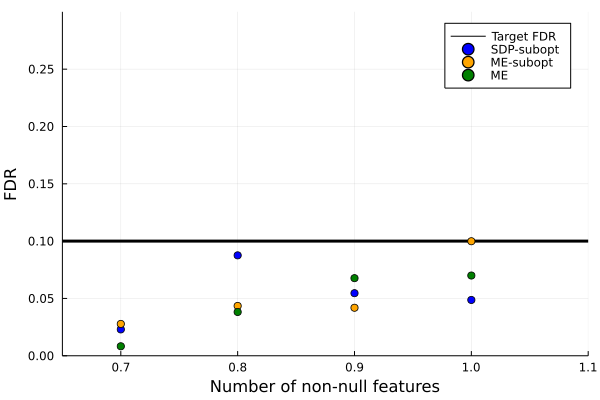

In [65]:
fdr_plt = plot(; xlim=(0.65, 1.1), xlabel="Number of non-null features", ylim=(0, 0.3), ylabel="FDR")
hline!(fdr_plt, [target_fdr], label="Target FDR", w=3, color="black")
scatter!(fdr_plt, c_corrs, sdp_fdr ./ nsims, label="SDP-subopt", color="blue")
scatter!(fdr_plt, c_corrs, mvr_fdr ./ nsims, label="ME-subopt", color="orange")
scatter!(fdr_plt, c_corrs, me_fdr ./ nsims, label="ME", color="green")

## Lasso Example

see the empirical power and FDR group knockoffs over 10 simulations when the targer FDR is 10%. Here power and FDR is defined at the group level. 

In [49]:
target_fdr = 0.1
group_powers, group_fdrs, group_times, group_s = Float64[], Float64[], Float64[], Float64[]

Random.seed!(2022)
for sim in 1:10
    # simulate X
    Random.seed!(sim)
    n = 1000 # sample size
    p = 200  # number of covariates
    k = 10   # number of true predictors
    Σ = Matrix(SymmetricToeplitz(0.9.^(0:(p-1)))) # true covariance matrix
    groupsizes = [5 for i in 1:div(p, 5)] # each group has 5 variables
    groups = vcat([i*ones(g) for (i, g) in enumerate(groupsizes)]...) |> Vector{Int}
    true_mu = zeros(p)
    L = cholesky(Σ).L
    X = randn(n, p) * L
    zscore!(X, mean(X, dims=1), std(X, dims=1)); # standardize columns of X

    # simulate y
    βtrue = zeros(p)
    βtrue[1:k] .= rand(-1:2:1, k) .* 0.1
    shuffle!(βtrue)
    correct_groups = get_signif_groups(βtrue, groups)
    ϵ = randn(n)
    y = X * βtrue + ϵ;

    # group MVR knockoffs
    t = @elapsed ko_filter = fit_lasso(y, X, method=:maxent, groups=groups)
    fdr_idx = findfirst(x -> x == target_fdr, ko_filter.fdr_target)
    power = round(TP(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    fdr = round(FDR(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    println("Sim $sim group-knockoff power = $power, FDR = $fdr, time=$t")
    push!(group_powers, power); push!(group_fdrs, fdr); push!(group_times, t)
    GC.gc();GC.gc();GC.gc();
end

println("\nME group knockoffs have average group power $(mean(group_powers))")
println("ME group knockoffs have average group FDR $(mean(group_fdrs))")
println("ME group knockoffs took average $(mean(group_times)) seconds");

Sim 1 group-knockoff power = 0.0, FDR = 0.0, time=5.356796708
Sim 2 group-knockoff power = 0.1, FDR = 0.0, time=3.846174709
Sim 3 group-knockoff power = 0.222, FDR = 0.0, time=2.418540375
Sim 4 group-knockoff power = 0.4, FDR = 0.2, time=3.774003875
Sim 5 group-knockoff power = 0.4, FDR = 0.0, time=2.337522042
Sim 6 group-knockoff power = 0.0, FDR = 0.0, time=3.913260458
Sim 7 group-knockoff power = 0.222, FDR = 0.333, time=2.531130667
Sim 8 group-knockoff power = 0.0, FDR = 0.0, time=3.927257125
Sim 9 group-knockoff power = 0.0, FDR = 0.0, time=3.9803245
Sim 10 group-knockoff power = 0.1, FDR = 0.0, time=2.300255291

ME group knockoffs have average group power 0.1444
ME group knockoffs have average group FDR 0.0533
ME group knockoffs took average 3.438526575 seconds


## Conclusion

+ When variables are highly correlated so that one cannot find exact discoveries, group knockoffs may be useful as it identifies whether a group of variables are non-null without having to pinpoint the exact discovery.
+ Group knockoffs control the group FDR to be below the target FDR level. 
+ Groups do not have to be contiguous
